# Introduction:
The people of Malawi have experienced an array of natural disasters and climatic shocks in recent years, including droughts, floods and landslides. The economic impacts of these disasters, coupled with Covid-19 and other global issues, negatively affect the health and wellbeing of most Malawians. People living in rural areas (more than 80% of Malawians) have been hit hardest.

There have been great strides in mapping flood extents and corresponding damages caused by these floods around the world, using satellite imagery. However, there are still gaps in determining the real number of affected populations, especially in rural areas in Malawi. Many houses in rural areas are often constructed with traditional grass-thatched roofs, and these are missed by the algorithms using satellite or aerial imagery to count populations or identify buildings affected by floods.

## Objectives:
The objective of this competition is to create a machine-learning algorithm that counts the number of grass-thatch, tin and other roofed houses in aerial (drone) imagery. Ensuring more accurate estimates of affected populations in the case of a disaster allows these communities to be evacuated or for aid to be provided more effectively, helping to improve response times and save lives in rural Malawi.

## Coding environment

This notebook was trained with NVIDIA RTX A6000 and it takes roughly 20 hours  to train.

## Data processing

Data preprocessing, particularly oversampling based on error analysis, became pivotal due to significant class imbalances within our dataset. To address this challenge, we applied several techniques aimed at augmenting the minority classes. These techniques helped increase the representation of underrepresented classes, thereby enhancing the model's ability to generalize across all categories. Prior to this, we filtered the background images and retained only 10% for training. In this notebook, the augmentation techniques we utilized include:

* **Copy-Paste:**
The copy-paste technique involves inserting foreground objects or elements from one image (such as annotated objects) onto another background image. This method effectively diversifies training data by combining annotated objects with various background scenes. By leveraging this technique, we aimed to enhance the dataset's diversity and ensure that the model learns to recognize objects in different contextual settings.



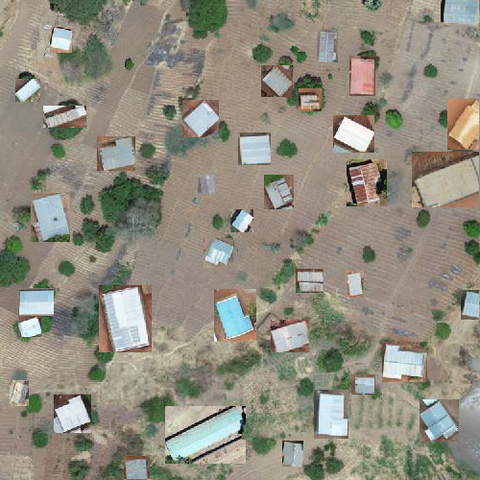

* **Random Image Masking:**
Random image masking involves applying random geometric shapes or patterns to obscure parts of an image. This technique serves multiple purposes, including data augmentation and regularization. By randomly masking regions of the image with shapes like polygons, circles, triangles, or rectangles, we aimed to simulate occlusions or varying environmental conditions. This approach encourages the model to focus on relevant features and improves its robustness to noise and partial occlusions in real-world scenarios.



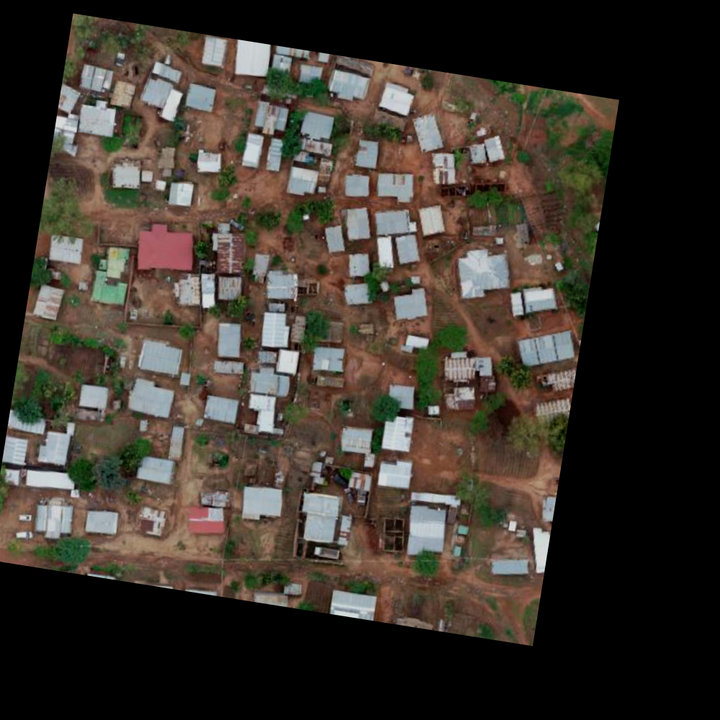

* **Masked Scale:**
Masked scale involves resizing and masking images to simulate various scales and viewpoints of objects within the image. Each chosen image is resized to 768x768 pixels and then placed randomly within a 1000x1000 pixel canvas, with additional random rotations of up to ±45 degrees. This technique augments the dataset by generating variations in object sizes and positions relative to the image frame. Scaling and masking images aim to enhance the model's capability to generalize across different object sizes and orientations by exposing it to diverse perspectives and scales.



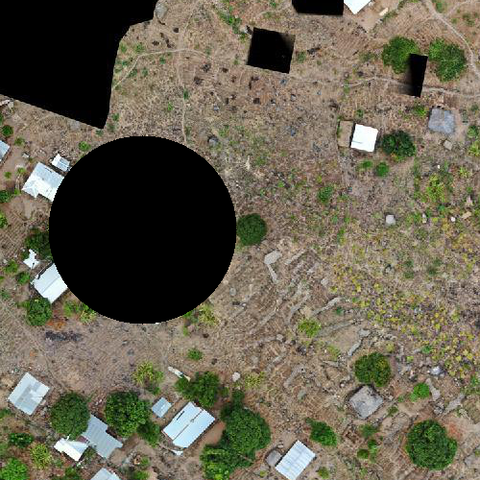

* **Collage:**
The collage technique involves assembling smaller images into cohesive visual compositions. Initially, images of a specific size (500x500 pixels) are selected from a dataset. These selected images are grouped into sets of four and arranged on a 1000x1000 pixel canvas using predefined positions. This process creates composite images that combine multiple visual elements into a unified whole. Collages are useful in various contexts, such as creating artistic compositions, generating presentation materials, or enhancing machine learning models by providing aggregated visual data that improves model understanding and performance.

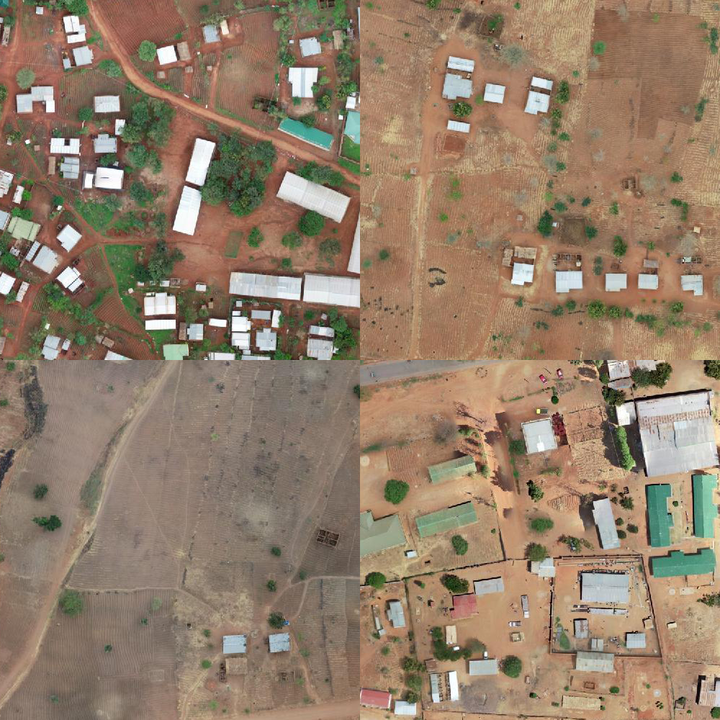

# Model

In this notebook, we use the efficientnetv2_rw_s model with an image size of 1024, a training batch size of 8, and train for 25 epochs.

# Setup-Env

In [1]:
%%capture
!pip install transformers==4.38.2 timm==0.9.16 pytorch_lightning==2.2.1 datasets==2.3.2 torchmetrics==1.3.2 albumentations==1.0.3 scikit-learn==1.2.2 imutils==0.5.4 shapely==2.0.4

# Imports

In [2]:
import random as rd
import pandas as pd
import os
import cv2
import re
import imutils
import albumentations as A
from random import randint, choice, choices
import random
import ast
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import torch
from torch import nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from tqdm.auto import tqdm
import pathlib
import torchvision.models as models
from sklearn.model_selection import GroupKFold, train_test_split, StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score , balanced_accuracy_score, log_loss
from torch.optim.lr_scheduler import StepLR
import numpy as np
from torchvision import transforms
import timm
import albumentations
from sklearn.metrics import log_loss
from torch.utils.data import Dataset
import torch
import pytorch_lightning as pl
from transformers import get_cosine_schedule_with_warmup
import torchmetrics
from tqdm.auto import tqdm
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import mean_absolute_error
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from joblib import Parallel, delayed
import warnings
device = "cuda" if torch.cuda.is_available() else "cpu"
warnings.simplefilter('ignore')

# Utils

In [3]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
def split_function(
    df,
    n_splits,
    method="groupkfold",
    target_col="",
    unique_id=""
    
):
    """
    Splits a DataFrame into folds for cross-validation.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to split.
    - n_splits (int): Number of folds.
    - method (str): The method to use for splitting. Options are 'groupkfold' and 'stratifiedgroupkfold'.
    - target_col (str): The name of the target column.
    - unique_id (str): The name of the column with unique group identifiers.
    
    Returns:
    - pd.DataFrame: The input DataFrame with an added 'fold' column indicating the fold assignment.
    """
    
    set_seed(seed=42)
    df = df.copy()
    if method == "groupkfold":
        folds = GroupKFold(n_splits=n_splits)
    elif method == "straitifiedgroupkfold":
        folds = StratifiedGroupKFold(n_splits=n_splits)
    df['fold'] = -1
    for i,(train_index, test_index) in enumerate(
        folds.split(
            df,
            df[target_col], 
            groups=df[unique_id]
        )
    ): 
        df.loc[test_index,'fold'] = i
    return df

def create_background_df(
    df,
    downsample_factor = 0.2
):
    """
    Creates a background DataFrame by filtering and downsampling the input DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing image data.
    - downsample_factor (float): The fraction of the background data to sample. Default is 0.2.
    
    Returns:
    - pd.DataFrame: A downsampled DataFrame containing background images with label columns set to 0.
    """
    background = df[df['bbox'].isna()][['image_id']]
    for col in CFG.data_preparation.labels: 
        background[col] = 0
    background = background.sample(frac=downsample_factor, random_state=CFG.seed)
    return background


def create_target_df(
    df
):
    """
    Prepares a DataFrame for training by processing image paths, extracting image dimensions,
    splitting into folds, and adding background images.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing image data and annotations.
    
    Returns:
    - original_df (pd.DataFrame): The original DataFrame with added image dimensions and processed bounding boxes.
    - result_df (pd.DataFrame): The DataFrame ready for training, including fold information and background images.
    """
    
    df = df.copy()
    
    # create_path_column
    df['path'] = df['image_id'].apply(
        lambda id_ : os.path.join(
            CFG.data_preparation.images_path,
            f"{id_}.tif"
        )
    )
    
    # Assuming 'all_paths' is a list of all unique image paths from train set
    all_paths = df.path.unique().tolist()

    # Use joblib to process paths in parallel and get results
    results = Parallel(n_jobs=-1)(
        delayed(process_path)(path) for path in tqdm(all_paths)
    )

    # Initialize dictionaries to store widths and heights
    width_mapper = {}
    height_mapper = {}

    # Populate the dictionaries with the results
    for path, width, height in results:
        width_mapper[path] = width
        height_mapper[path] = height

    # create width, height columns (to be used in yolo conversion)
    df['width'] = df['path'].map(width_mapper)
    df['height'] = df['path'].map(height_mapper)
    
    
    # will be used later for oversampling
    original_df = df.copy()
    
    # split function
    split_df = split_function(
        df,
        n_splits=CFG.data_preparation.n_splits,
        unique_id=CFG.data_preparation.group_col,
        target_col=CFG.data_preparation.split_col,
    )
    
    # get background images
    background = create_background_df(
        df,
        downsample_factor=CFG.data_preparation.downsample_factor
    )
    
    df = df[df['category_id'].isin(CFG.data_preparation.targets)].reset_index(drop=True)
    
    category_counts = df.groupby(
        ['image_id', 'category_id']
    ).size().reset_index(name='count')
    
    result_df = category_counts.pivot_table(
        index='image_id',
        columns='category_id',
        values='count',
        fill_value=0
    ).reset_index()
    result_df.columns = ['image_id'] + CFG.data_preparation.labels
    
    for col in CFG.data_preparation.labels:
        result_df[col] = result_df[col].astype(int)
        
    result_df=pd.concat([result_df, background], axis = 0).reset_index(drop=True)
    
    result_df['count'] = result_df[CFG.data_preparation.labels].sum(axis=1)
    result_df = pd.merge(result_df, split_df[['image_id','fold']], on='image_id', how='left').drop_duplicates()
    
    result_df['path'] = result_df['image_id'].apply(
        lambda id_ : os.path.join(
            CFG.data_preparation.images_path,
            f"{id_}.tif"
        )
    )
    original_df.loc[~original_df['bbox'].isna(), 'bbox'] = original_df.loc[~original_df['bbox'].isna(), 'bbox'].apply(decode_points)
    original_df.loc[~original_df['bbox'].isna(), 'area'] = original_df.loc[~original_df['bbox'].isna(), 'bbox'].apply(lambda box: box[2] * box[3])
    original_df.loc[~original_df['bbox'].isna(), 'bbox'] = original_df.loc[~original_df['bbox'].isna(), 'bbox'].apply(lambda box: str(box))    
    return original_df, result_df

In [4]:
def process_path(path):
    """
    Reads an image and returns its path along with its width and height.
    Parameters:
    - path: str, the path to the image file.
    Returns:
    - tuple: (path, width, height)
    """
    img = cv2.imread(path)
    height, width, _ = img.shape  # Get image dimensions
    return (path, width, height)


# filter bad background data
def bad_background(path):
    """
    Determines if an image has a bad background based on its mean pixel values.
    
    Parameters:
    - path (str): The file path of the image.
    
    Returns:
    - bool: True if the background is bad, False otherwise.
    """
    bad_background = False
    image = cv2.imread(path)
    mean_values = image.mean()
    if (mean_values<=10) or (mean_values>=240):
        bad_background = True
    return bad_background
    
def decode_points(ddbox: str) -> list:
    """
    Decodes a bounding box string into a list of integers.
    
    Parameters:
    - ddbox (str): The bounding box string to decode.
    
    Returns:
    - list: A list of integers representing the bounding box coordinates.
    """
    points = [int(float(point)) for point in re.findall(r'\d+\.\d+', ddbox)]
    return points



def can_place_object(new_bbox, existing_bboxes, background_image):
    """
    Checks if a new bounding box can be placed on an image without overlapping existing bounding boxes
    and ensures the region has an appropriate intensity.

    Parameters:
    - new_bbox (list): The new bounding box coordinates [x, y, width, height].
    - existing_bboxes (list): A list of existing bounding boxes.
    - background_image (ndarray): The image on which the bounding box will be placed.

    Returns:
    - bool: True if the new bounding box can be placed, False otherwise.
    """
    for bbox in existing_bboxes:
        if (new_bbox[0] < bbox[0] + bbox[2] and new_bbox[0] + new_bbox[2] > bbox[0] and
            new_bbox[1] < bbox[1] + bbox[3] and new_bbox[1] + new_bbox[3] > bbox[1]):
            return False
    roi = background_image[new_bbox[1]:new_bbox[1]+new_bbox[3], new_bbox[0]:new_bbox[0]+new_bbox[2]]
    avg_intensity = np.mean(roi)
    if avg_intensity > 200 or avg_intensity < 50:
        return False
    return True

In [5]:
# Function to process a single background image
def process_background_image(
    bg_row,
    labels_data,
    folder_path,
    seed,
    idx
):
    """
    Processes a single background image by copy-pasting objects from the annotated data.

    Parameters:
    - bg_row (pd.Series): A row from the background data DataFrame.
    - labels_data (pd.DataFrame): DataFrame containing annotated objects and their metadata.
    - folder_path (str): Path to the folder where processed images will be saved.
    - seed (int): Seed for random number generation to ensure reproducibility.
    - idx (int): Index of the current background image.

    Returns:
    - pd.DataFrame: DataFrame containing metadata of the new images with pasted objects.
    """
    set_seed(seed=seed+idx+1)
    tmp_data = pd.DataFrame(columns=labels_data.columns)
    n_obj_candidates = random.randint(2, 100)
    background_image = cv2.imread(bg_row.path)
    bg_height, bg_width, _ = background_image.shape
    
    sampled_annotated_data = labels_data[
        labels_data['height'] == bg_height
    ].sample(
        frac=1.0,
        random_state=n_obj_candidates
    ).sample(
        n=n_obj_candidates,
        random_state=seed * n_obj_candidates
    )
    
    copy_pasted_bboxes = []
    images_id = []
    images_path = []
    images_width = []
    images_height = []
    obj_categories = []
    save_path = os.path.join(
        folder_path,
        f"{bg_row.image_id}.tif"
    )

    for annot_idx, annot_row in sampled_annotated_data.iterrows(): 
        object_bbox =  eval(annot_row.bbox)
        category_id = annot_row.category_id
        annot_image = cv2.imread(annot_row.path)
        if can_place_object(object_bbox, copy_pasted_bboxes,background_image):
            background_image[
                object_bbox[1]:object_bbox[1] + object_bbox[3],
                object_bbox[0]:object_bbox[0] + object_bbox[2]
            ] = annot_image[
                object_bbox[1]:object_bbox[1] + object_bbox[3],
                object_bbox[0]:object_bbox[0] + object_bbox[2]
            ]
            copy_pasted_bboxes.append(object_bbox)
            images_id.append(bg_row.image_id)
            images_path.append(save_path)
            images_width.append(bg_width)
            images_height.append(bg_height)
            obj_categories.append(category_id)

    cv2.imwrite(save_path, background_image)
    
    tmp_data['image_id'] = images_id
    tmp_data['width'] = images_width
    tmp_data['height'] = images_height
    tmp_data['path'] = images_path
    tmp_data['category_id'] = obj_categories
    tmp_data['bbox'] = copy_pasted_bboxes
    return tmp_data

# Main function using Joblib
def copy_paste(
    labels_data,
    background_data,
    folder_path,
    seed
):
    """
    Performs copy-pasting of objects onto background images in parallel.

    Parameters:
    - labels_data (pd.DataFrame): DataFrame containing annotated objects and their metadata.
    - background_data (pd.DataFrame): DataFrame containing background images metadata.
    - folder_path (str): Path to the folder where processed images will be saved.
    - seed (int): Seed for random number generation to ensure reproducibility.

    Returns:
    - pd.DataFrame: DataFrame containing metadata of the new images with pasted objects.
    """
    # Initialize new DataFrame for results
    new_data = pd.DataFrame(columns=labels_data.columns)
    # Run processing in parallel
    results = Parallel(n_jobs=-1, backend='multiprocessing')(
        delayed(process_background_image)(
            bg_row,
            labels_data,
            folder_path,
            seed,
            idx,
        )
        for idx, bg_row in tqdm(
            background_data.iterrows(),
            total=len(background_data)
        )
    )

    # Combine results into a single DataFrame
    new_data = pd.concat(results).reset_index(drop=True)
    return new_data

In [6]:
def random_image_masking(image, boxes, y):
    """
    Applies random masking to an image by drawing random shapes and then checks
    if the bounding boxes are still valid based on the mean pixel value inside the box.

    Parameters:
    - image (ndarray): The input image.
    - boxes (list): List of bounding boxes.
    - y (list): List of labels corresponding to the bounding boxes.

    Returns:
    - tuple: The masked image, updated bounding boxes, and updated labels.
    """
        
    mask_count = randint(1, 3)
    height, width, _ = image.shape

    # Define a list of functions that generate different shapes
    def draw_polygon():
        points = np.array([(randint(0, width), randint(0, height)) for _ in range(4)], dtype=np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.fillPoly(image, [points], (0, 0, 0))

    def draw_circle():
        center = (randint(0, width), randint(0, height))
        radius = randint(10, min(height, width) // 4)
        cv2.circle(image, center, radius, (0, 0, 0), thickness=-1)

    def draw_triangle():
        points = np.array([(randint(0, width), randint(0, height)) for _ in range(3)], dtype=np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.fillPoly(image, [points], (0, 0, 0))

    def draw_rectangle():
        pt1 = (randint(0, width), randint(0, height))
        pt2 = (randint(pt1[0], width), randint(pt1[1], height))
        cv2.rectangle(image, pt1, pt2, (0, 0, 0), thickness=-1)

    shape_functions = [draw_polygon, draw_circle, draw_triangle, draw_rectangle]

    for _ in range(mask_count):
        # Randomly select and draw a shape
        shape_func = choice(shape_functions)
        shape_func()

    # Calculate if boxes are still valid
    new_boxes = []
    new_y = []
    for box, label in zip(boxes, y):
        box = ast.literal_eval(box)  # ensure box is in tuple/list form if coming from a string
        box = list(map(int, box))
        # Check mean pixel value in the box to decide if it should be kept
        if np.mean(
            image[
                box[1]:box[3] + box[1],
                box[0]:box[2] + box[0],
            ]
        ) > 5:  # Check mean pixel value in the box
            new_boxes.append(box)
            new_y.append(label)

    return image, new_boxes, new_y


def random_masking(
    labels_data,
    columns,
    output_directory,
    seed=42
):
    """
    Applies random masking to images in a dataset and saves the augmented images.

    Parameters:
    - labels_data (pd.DataFrame): DataFrame containing image paths and bounding boxes.
    - columns (list): List of columns for the temporary DataFrame.
    - output_directory (str): Directory where augmented images will be saved.
    - seed (int): Seed for random number generation.

    Returns:
    - pd.DataFrame: DataFrame containing metadata of the new images with augmented objects.
    """
    
    # initialize final data
    final_data = pd.DataFrame()
    
    !rm -r $output_directory
    os.makedirs(output_directory, exist_ok=False)
    random.seed(seed)
    
    n_candidates = randint(50, 200)
    image_paths = labels_data.drop_duplicates('path').path.tolist()
    selected_images = choices(image_paths, k=n_candidates)
    
    for idx, path in tqdm(enumerate(selected_images)):
        tmp_data = pd.DataFrame(columns=columns)
        subdf = labels_data[labels_data['path']==path]
        image = cv2.imread(path)
        boxes = subdf.bbox.tolist()
        y = subdf.category_id.tolist()

        new_image, updated_boxes, updated_y = random_image_masking(
            image,
            boxes,
            y
        )
        
        updated_path = os.path.join(
            output_directory,
            os.path.basename(path)
        )
        tmp_data['bbox'] = updated_boxes
        tmp_data['category_id'] = updated_y
        tmp_data['path'] = updated_path
            
        # Save the augmented image
        cv2.imwrite(
            updated_path,
            new_image
        )
        
        # update final data
        final_data = pd.concat(
            [
                final_data,
                tmp_data
            ]
        ).reset_index(drop=True)
    
    # Count the occurrences of each category per image_id
    category_counts = final_data.groupby(['path', 'category_id']).size().unstack(fill_value=0)

    # Rename columns as required
    category_counts.columns = [f'category_{int(x-1)}' for x in category_counts.columns]
    for col in ['category_0', 'category_1', 'category_2']:
        if col not in category_counts.columns:
            category_counts[col] = 0
    # Merge this with the original DataFrame on 'image_id'
    result_data = final_data.merge(category_counts.reset_index(), on='path', how='left').copy()
    result_data['count'] = 0
    result_data['fold'] = 0
    result_data = result_data.drop_duplicates('path')
    
    return result_data

In [7]:
def masked_scale(
    labels_data,
    output_directory,
    seed=42
):
    """
    Apply random transformations to images, create masks, and save the augmented images.

    Parameters:
    - labels_data (pd.DataFrame): DataFrame containing image paths and bounding boxes.
    - output_directory (str): Directory where augmented images will be saved.
    - seed (int): Seed for random number generation.

    Returns:
    - pd.DataFrame: DataFrame containing metadata of the new images with augmented objects.
    """
    # initialize final data
    final_data = pd.DataFrame()
    
    !rm -r $output_directory
    os.makedirs(output_directory, exist_ok=False)
    random.seed(seed)
    
    # algo inputs
    labels_data = labels_data[labels_data['height']==500].copy()
    other_images = labels_data[labels_data['category_id']==1].drop_duplicates('path').path.tolist()
    thatch_images = labels_data[labels_data['category_id']==3].drop_duplicates('path').path.tolist()
    selected_images = labels_data.drop_duplicates('path').sample(n=150, random_state=seed).path.tolist()
    
    # Ensuring at least 50 'Thatch' images if possible
    selected_thatch_images = [img for img in selected_images if img in thatch_images]
    selected_other_images = [img for img in selected_images if img in other_images]

    if len(selected_thatch_images) < 50:
        additional_thatch = [img for img in thatch_images if img not in selected_images]
        selected_images += choices(additional_thatch, k=50 - len(selected_thatch_images))
        
    if len(selected_other_images) < len(other_images):
        additional_other = [img for img in other_images if img not in selected_images]
        selected_images += additional_other
    
    # Load images, create masks, apply transformations, and save
    transform = A.Compose([
        A.Resize(768, 768, p=0.75),
        A.HorizontalFlip(p=1.0), 
        A.VerticalFlip(p=1.0),
        A.RandomBrightnessContrast(p=1.0),
    ])

    for idx, image_path in tqdm(enumerate(selected_images)):
        tmp_data = labels_data[labels_data['path']==image_path]
        new_path = os.path.join(
            output_directory,
            os.path.basename(image_path)
        )
        tmp_data['path'] = new_path
        random.seed(seed+1+idx)
        image = cv2.imread(image_path)
        
        # Apply albumentations
        image = transform(image=image)['image']
        
        # create empty mask
        mask = np.zeros((1000, 1000, 3), dtype=np.uint8)
        # Randomly place image in mask
        x_offset = randint(0, 1000 - image.shape[1])
        y_offset = randint(0, 1000 - image.shape[0])
        mask[y_offset:y_offset+image.shape[0], x_offset:x_offset+image.shape[1]] = image
        
        # Apply rotation using imutils
        angle = randint(-45, 45)
        mask = imutils.rotate(mask, angle)
        
        # Save the augmented image
        cv2.imwrite(
            new_path,
            mask
        )
        
        # update final data
        final_data = pd.concat(
            [
                final_data,
                tmp_data
            ]
        ).reset_index(drop=True)
    
    # Count the occurrences of each category per image_id
    category_counts = final_data.groupby(['path', 'category_id']).size().unstack(fill_value=0)

    # Rename columns as required
    category_counts.columns = [f'category_{int(x-1)}' for x in category_counts.columns]
    for col in ['category_0', 'category_1', 'category_2']:
        if col not in category_counts.columns:
            category_counts[col] = 0
    # Merge this with the original DataFrame on 'image_id'
    result_data = final_data.merge(category_counts.reset_index(), on='path', how='left').copy()
    result_data['count'] = 0
    result_data['fold'] = 0
    result_data = result_data.drop_duplicates('path')
    
    return result_data

In [8]:
def filter_images(labels_data, size=(500, 500)):
    """
    Filters images from labels_data based on the specified size.

    Parameters:
    - labels_data (pd.DataFrame): DataFrame containing image paths.
    - size (tuple): Desired size of images (width, height).

    Returns:
    - pd.DataFrame: DataFrame containing only images of the specified size.
    """
    filtered_images = pd.DataFrame()
    for filename in labels_data['path']:
        with Image.open(filename) as img:
            if img.size == size:
                filtered_images = pd.concat([filtered_images, labels_data[labels_data['path'] == filename]], axis=0)
    return filtered_images.reset_index(drop=True)

def create_collage(images, output_path, size=(1000, 1000)):
    """
    Creates a collage from a list of images and saves it to the specified output path.

    Parameters:
    - images (pd.DataFrame): DataFrame containing image paths.
    - output_path (str): Path to save the resulting collage image.
    - size (tuple): Size of the collage image (width, height).
    """
    collage = Image.new('RGB', size)
    positions = [(0, 0), (0, 500), (500, 0), (500, 500)]
    for i, image_path in enumerate(images['path']):
        with Image.open(image_path) as img:
            collage.paste(img, positions[i])
    collage.save(output_path)

def collage(labels_data, output_directory):
    """
    Creates collages from the filtered images and saves them to the output directory.

    Parameters:
    - labels_data (pd.DataFrame): DataFrame containing image paths and categories.
    - output_directory (str): Directory to save the resulting collages.

    Returns:
    - pd.DataFrame: DataFrame containing metadata of the new collages.
    """
    if os.path.exists(output_directory):
        os.system(f"rm -r {output_directory}")
    os.makedirs(output_directory, exist_ok=True)
    
    filtered_images = filter_images(labels_data, size=(500, 500))
    final_data = pd.DataFrame()
    
    for i in range(0, len(filtered_images), 4):
        if i + 3 < len(filtered_images):
            selected_images = filtered_images.iloc[i:i + 4]
            output_path = os.path.join(output_directory, f"collage_{i//4 + 1}.tif")
            
            tmp_data = pd.DataFrame({
                'path': [output_path],
                'image_id':f"collage_{i//4 + 1}",
                'category_0': [selected_images['category_0'].sum()],
                'category_1': [selected_images['category_1'].sum()],
                'category_2': [selected_images['category_2'].sum()],
                'count': [selected_images['category_0'].sum()+selected_images['category_1'].sum()+selected_images['category_2'].sum()],
                'fold': [0]
            })
            final_data = pd.concat([final_data, tmp_data], axis=0)
            create_collage(selected_images, output_path)
    return final_data.reset_index(drop=True)

In [9]:
class ImageDataset(Dataset):
    def __init__(
        self,
        df,
        config,
        transform=None,
        mode='training'
    ):
        """
        Initializes the dataset with a DataFrame, configuration, transforms, and mode.

        Parameters:
        - df (pd.DataFrame): DataFrame containing the dataset information.
        - config (object): Configuration object with necessary parameters.
        - transform (callable, optional): A function/transform to apply to the images.
        - mode (str): Mode of the dataset, either 'training' or 'inference'.
        """
        self.transform = transform
        self.df =df
        self.mode = mode
        self.config = config
    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves the image and its corresponding target for a given index.

        Parameters:
        - idx (int): Index of the sample to retrieve.

        Returns:
        - If mode is 'training': (image, target) tuple.
        - If mode is 'inference': image only.
        """
        row = self.df.loc[idx]
        image = Image.open(row[self.config.training_params.image_path_col])
        # Transform if necessary
        if self.transform:
            image = self.transform(
                image=np.array(image)
            )['image']
        if self.mode =='training':
            target = list(row[self.config.data_preparation.labels])
            return image, target
        else:
            return image

In [10]:
# This class is designed to crop the borders of an image and then pad it back to its original size.
class CropBorders:
    def __init__(self, border_size):
        self.border_size = border_size
        
    def __call__(
        self,
        img,
        **kwargs
    ):
        height, width = img.shape[:2]
        new_height = height - 2 * self.border_size
        new_width = width - 2 * self.border_size
        cropped_img = img[
                    self.border_size:height-self.border_size, 
                    self.border_size:width-self.border_size
        ]
        padded_img = np.zeros(
            (height, width, img.shape[2]), 
            dtype=img.dtype
        )
        # Place the cropped image back into the center of the padded image.
        padded_img[
            self.border_size:new_height+self.border_size,
            self.border_size:new_width+self.border_size
        ] = cropped_img
        return padded_img
    
# This class handles data augmentation configurations.   
class Augmentation :
    def __init__(self, config) :
        self.input_shape = config.training_params.image_size
        self.SEED_VAL  = config.seed

    def seed_all(self):
        random.seed(self.SEED_VAL)
        np.random.seed(self.SEED_VAL)
        torch.manual_seed(self.SEED_VAL)
        torch.cuda.manual_seed_all(self.SEED_VAL)
        os.environ['PYTHONHASHSEED'] = str(self.SEED_VAL)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def train_transform(self, visualize=False) :
        self.seed_all()
        augs_list = [
            A.Resize(height=self.input_shape[0], width=self.input_shape[1], p=1.0),
            A.HorizontalFlip(p=0.5),
            A.Transpose(p=0.5),  # Transpose the input with a probability of 0.5
            A.RandomRotate90(p=0.5),  # Randomly rotate the input by 90 degrees with a probability of 0.5
            A.GaussianBlur(p=0.15),  # Apply Gaussian Blur to the input
            A.GaussNoise(p=0.25),  # Apply Gaussian Noise to the input
            
        ]
        if not visualize:
                augs_list.extend(
                 [
                     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),
                     ToTensorV2(),
                 ]   
                )
        train_transform = A.Compose(augs_list)
        return train_transform
    
    # Define the transformations to be applied during testing.
    def test_trasnform(self, aug_type='Basic') :
        if aug_type == 'Basic' :
            test_transform = A.Compose([ 
                                      A.Resize(height=self.input_shape[0], width=self.input_shape[1], p=1),
                                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),
                                      ToTensorV2(),
                                      ])
        elif aug_type == 'CropBorders' :
            test_transform = A.Compose([ 
                                    A.RandomRotate90(p=0.5),
                                    A.HorizontalFlip(p=0.5),
                                    A.Resize(height=self.input_shape[0], width=self.input_shape[1], p=1.0),
                                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),
                                    ToTensorV2(),
                                      ])
        return test_transform

In [11]:
def load_image(image_path):
    """Load an image from the disk."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB format
    return image

def augment_image(image, augmentation_pipeline):
    """Apply the augmentation pipeline to an image."""
    augmented = augmentation_pipeline(image=image)
    return augmented['image']

def display_augmented_images(
    df,
    augmentation_pipeline,
    column_name,
    num_images=25
):
    """Display a 5x5 grid of augmented images from a dataframe.

    Args:
    df (pd.DataFrame): Dataframe containing images or paths to images.
    column_name (str): The column name where image paths or images are stored.
    num_images (int): Total number of images to display (default 25, should be a perfect square for a grid).
    """
    fig, axs = plt.subplots(5, 5, figsize=(15, 15))
    fig.suptitle('5x5 Grid of Augmented Images')

    for i in range(5):
        for j in range(5):
            set_seed(42 * (i+1)*(j+1))
            idx = np.random.randint(0, len(df))  # Randomly select an image from the dataframe
            image_data = df.iloc[idx][column_name]

            # Load image if the dataframe contains paths
            if isinstance(image_data, str):
                image = load_image(image_data)
            else:
                image = image_data  # Assume it's an array

            augmented_image = augment_image(image, augmentation_pipeline)
            axs[i, j].imshow(augmented_image)
            axs[i, j].axis('off')
    
    plt.show()

In [12]:
class LitModel(pl.LightningModule):
    """
    PyTorch Lightning module for training and validation of a model for palm tree counting.
    
    Parameters:
    lr (float): Learning rate for the optimizer.
    weight_decay (float, optional): Weight decay for the optimizer. Default is 1e-4.
    warmup_steps (int, optional): Number of warmup steps for the learning rate scheduler. Default is 0.
    """
    def __init__(self, lr, weight_decay=1e-4, warmup_steps=0):
        super().__init__()
        self.save_hyperparameters()
        self.model = HouseCounter(CFG).to(CFG.device)
        self.criterion = nn.L1Loss()
        self.val_accuracy = torchmetrics.MeanAbsoluteError()
        self.train_accuracy = torchmetrics.MeanAbsoluteError()

    def training_step(self, batch, batch_idx#, optimizer_idx=None
                     ):
        """
        Training step for a single batch.
        
        Parameters:
        batch (tuple): Batch of data containing inputs and targets.
        batch_idx (int): Index of the batch.
        
        Returns:
        torch.Tensor: The loss value for the batch.
        """
        x, targets = batch
        out = self.model(x)
        loss = self.criterion(out, torch.stack(targets, dim=1).float())
        self.log('loss', loss)
        self.train_accuracy.update(out, torch.stack(targets, dim=1))
        optimizer = self.optimizers()
        self.log('lr', optimizer.param_groups[0]['lr'], prog_bar=True)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step for a single batch.
        
        Parameters:
        batch (tuple): Batch of data containing inputs and targets.
        batch_idx (int): Index of the batch.
        
        Returns:
        torch.Tensor: The loss value for the batch.
        """
        x, targets = batch
        out = self.model(x)
        loss = self.criterion(out, torch.stack(targets, dim=1).float())
        self.val_accuracy.update(out, torch.stack(targets, dim=1))
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        """
        Actions to perform at the end of a validation epoch.
        
        Logs the Mean Absolute Error (MAE) for training and validation.
        Resets the accuracy metrics.
        """
        train_mae = self.train_accuracy.compute()
        self.log('train_mae', train_mae, prog_bar=True)
        self.train_accuracy.reset()
        # Compute MAE for all targets
        val_mae = self.val_accuracy.compute()
        self.log('val_mae', val_mae, prog_bar=True)
        self.val_accuracy.reset()

    def configure_optimizers(self):
        """
        Configures the optimizer and learning rate scheduler.
        
        Returns:
        tuple: The optimizer and the learning rate scheduler.
        """
        optimizer = torch.optim.Adam(
            self.parameters(), self.hparams.lr, weight_decay=self.hparams.weight_decay
        )
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, self.hparams.warmup_steps, self.trainer.estimated_stepping_batches
        )
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]
    
class SelfAttention(nn.Module):
    """
    Self-Attention mechanism for capturing long-range dependencies in image data.
    
    Parameters:
    in_channels (int): Number of input channels.
    key_channels (int, optional): Number of channels for the key and query. Defaults to in_channels // 8.
    value_channels (int, optional): Number of channels for the value. Defaults to in_channels // 2.
    out_channels (int, optional): Number of output channels. Defaults to in_channels.
    """
    def __init__(self, in_channels, key_channels=None, value_channels=None, out_channels=None):
        super(SelfAttention, self).__init__()
        self.key_channels = key_channels if key_channels is not None else in_channels // 8
        self.value_channels = value_channels if value_channels is not None else in_channels // 2
        self.out_channels = out_channels if out_channels is not None else in_channels

        self.query_conv = nn.Conv2d(in_channels, self.key_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, self.key_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, self.value_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.out_conv = nn.Conv2d(self.value_channels, self.out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        Forward pass of the Self-Attention mechanism.
        
        Parameters:
        x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).
        
        Returns:
        torch.Tensor: Output tensor of the same shape as the input tensor.
        """
        batch_size, channels, height, width = x.size()

        query = self.query_conv(x).view(batch_size, self.key_channels, -1)
        key = self.key_conv(x).view(batch_size, self.key_channels, -1)
        value = self.value_conv(x).view(batch_size, self.value_channels, -1)

        energy = torch.bmm(query.transpose(1, 2), key)
        attention = F.softmax(energy, dim=-1)

        out = torch.bmm(value, attention.transpose(1, 2))
        out = out.view(batch_size, self.value_channels, height, width)

        out = self.out_conv(out)
        out = self.bn(out)
        out = self.relu(out)

        out = self.gamma * out + x
        return out

class HouseCounter(nn.Module):
    """
    Neural network model for counting palm trees in images using a pre-trained backbone
    and self-attention mechanisms.
    
    Parameters:
    config (object): Configuration object containing training parameters.
    """
    def __init__(self, config):
        super(HouseCounter, self).__init__()
        self.model_name = config.training_params.model_name
        self.model = timm.create_model(
            self.model_name,
            pretrained=True
        )
        in_channels = config.training_params.attention_in_channels
        self.attention1 = SelfAttention(in_channels=in_channels)
        self.attention2 = SelfAttention(in_channels=in_channels)
        self.fc = nn.Linear(in_channels, 3)

    def forward(self, image):
        x = self.model.forward_features(image)
        x = self.attention1(x)
        x = self.attention2(x)
        x = x.mean(dim=[2, 3])
        x = self.fc(x)

        return x

In [13]:
def predict_on_data(
    dirpath,
    df,
    folds,
    image_path,
    aug,
    seed,
    mode='valid',
):
    """
    Function to predict on data using trained models across specified folds.
    
    Parameters:
    dirpath (str): Directory path where the model checkpoints are stored.
    df (pd.DataFrame): DataFrame containing the data and metadata for prediction.
    folds (list): List of fold indices to perform predictions on.
    image_path (str): Path to the directory containing images.
    aug (function): Augmentation function to apply to the images.
    seed (int): Seed for random operations to ensure reproducibility.
    mode (str): Mode of prediction, either 'valid' or 'test'. Default is 'valid'.
    
    Returns:
    tuple: A tuple containing:
        - all_predictions (list): List of all predictions made.
        - background_data_select_all (pd.DataFrame): DataFrame of selected background data for validation.
    """
    all_predictions = []
    background_data_select_all=pd.DataFrame()
    for fold in folds:
        print(f'--------------------------------Prediction Fold {fold+1}/5---------------------------------')
        if mode == 'valid':
            random.seed(seed*fold)
            predict_data = df[df['fold'] == fold].reset_index(drop=True)
            background_data_in_df = df[df['count'] == 0]['image_id'].values.tolist()
            background_data_in_val = predict_data[predict_data['count'] == 0]['image_id'].values.tolist()
            background_data_select_from = background_data[~background_data['image_id'].isin(background_data_in_df)]['image_id'].values.tolist()
            number_background_data_add = predict_data.shape[0] - 2*len(background_data_in_val)
            image_id_background_data_select = random.choices(background_data_select_from, k=number_background_data_add)
            background_data_select = background_data[background_data['image_id'].isin(image_id_background_data_select)]
            predict_data = pd.concat([predict_data, background_data_select], axis=0).reset_index(drop=True)
            background_data_select['fold']=fold
            background_data_select_all=pd.concat([background_data_select_all,background_data_select]).reset_index(drop=True)
        else:
            predict_data = df.copy().reset_index(drop=True)
            
        test_dataset = ImageDataset(
            predict_data,
            CFG,
            aug,
            mode='training' if mode == 'valid' else 'testing'
        )
        data_loader = torch.utils.data.DataLoader(
            test_dataset, 
            batch_size=CFG.training_params.valid_bs,
            shuffle=False,
            num_workers=CFG.training_params.num_workers
        )
    
        checkpoint_path = os.path.join(
            dirpath,
            f'best_model_fold_{fold+1}.ckpt' 
        )
        
        lit_model = LitModel.load_from_checkpoint(checkpoint_path)
        if torch.cuda.is_available():
            lit_model.cuda()
        lit_model.freeze()
        lit_model.eval()

        all_preds = []
        for batch in tqdm(data_loader):
            if mode == 'valid':
                x = batch[0].cuda()
            else:
                x = batch.cuda()
            out = lit_model.model(x)
            preds = [torch.relu(output).cpu().numpy() for output in out] 
            all_preds.extend(preds) 
        if mode == 'valid':
            all_predictions.extend(all_preds)
        else:
            all_predictions.append(all_preds)
        torch.cuda.empty_cache()
        gc.collect()
    return all_predictions,background_data_select_all

def generate_validation_report(
    df,
    folds,
    model_prediction,
    background_data_select,
    classes_columns = ['category_0', 'category_1', 'category_2']
):
    """
    Generates a validation report with Mean Absolute Error (MAE) scores for model predictions.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the ground truth data.
    folds (list): List of fold indices used in validation.
    model_prediction (list): List of model predictions.
    background_data_select (pd.DataFrame): DataFrame containing selected background data.
    classes_columns (list, optional): List of column names representing the target categories. Default is ['category_0', 'category_1', 'category_2'].
    
    Returns:
    dict: A dictionary with MAE scores for each category and a flattened category.
    """
    df_gt = pd.DataFrame()
    for fold in folds:
        df_with_back=pd.concat([df[df.fold==fold].reset_index(drop=True),
                                 background_data_select[background_data_select.fold==fold].reset_index(drop=True)]
                              ).reset_index(drop=True)
        df_gt = pd.concat(
            [
                df_gt,
                df_with_back
            ]
        ).reset_index(drop=True)

    df_predictions = pd.DataFrame(
        model_prediction,
        columns=classes_columns
    )
    
    # Calculating MAE for each target
    mae_scores = {col: mean_absolute_error(df_gt[col], df_predictions[col]) for col in classes_columns}
    gt = df_gt[classes_columns].values.reshape(-1, 1)
    pred = np.array(model_prediction).reshape(-1, 1)
    flatten_mae = mean_absolute_error(gt, pred)
    mae_scores['flatten_category'] = flatten_mae
    return mae_scores

In [14]:
import gc
import time
def free_memory(sleep_time=0.1) :
    """
    This function helps to free up memory by:
    1. Forcing garbage collection.
    2. Synchronizing CUDA operations.
    3. Emptying the CUDA cache.
    4. Introducing a sleep delay to ensure proper memory release.
    
    Parameters:
    sleep_time (float): Duration to pause execution after memory cleanup. Default is 0.1 seconds.
    """      
    gc.collect()
    torch.cuda.synchronize()
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(sleep_time)

free_memory(sleep_time=0.1)

# Config

In [15]:
class CFG:
    seed = 42
    device = 'cuda'
    class data_preparation:
        images_path = "kedro-zindi/data/dataset/Images/Images"
        train_path = "kedro-zindi/data/dataset/Train.csv"
        test_path = "kedro-zindi/data/dataset/Test.csv"
        ss_path = "kedro-zindi/data/dataset/SampleSubmission.csv"
        method = 'groupkfold'
        targets = [1, 2, 3]
        labels = ['category_0', 'category_1', 'category_2']
        group_col = 'image_id'
        split_col = 'category_id'
        n_splits = 5
        downsample_factor = 0.1
        
    class training_params:
        image_path_col = "path"
        model_name = 'efficientnetv2_rw_s'
        attention_in_channels = 1792
        num_classes = 3
        epochs = 25
        image_size = [1024,1024]
        num_workers =0
        train_bs = 8
        valid_bs = 32
        criterion = "l1loss"
        lr = 1e-4
        weight_decay = 1e-4
        warmup_steps = 0
        class model_checkpoint:
            monitor = 'val_loss'  
            mode = 'min'          
            dirpath = 'dataset/multilabelregression/'
            filename = 'best_model'

# Data

In [ ]:
train = pd.read_csv(CFG.data_preparation.train_path)
test = pd.read_csv(CFG.data_preparation.test_path)
ss = pd.read_csv(CFG.data_preparation.ss_path)

In [ ]:
original_train, train_data =  create_target_df(df=train)
train_data.head()

In [ ]:
train_data[['image_id', 'fold']].to_csv('common_split_data.csv', index=False)

In [22]:
# oversampling utlities
# get background data
background_data = original_train[~(original_train['category_id'].isin(CFG.data_preparation.targets))].reset_index(drop=True)
annotated_data = original_train[(original_train['category_id'].isin(CFG.data_preparation.targets))].reset_index(drop=True)

# Use joblib to process paths in parallel and get results
results = Parallel(n_jobs=-1)(
    delayed(bad_background)(path) for path in tqdm(background_data.path.tolist())
)
background_data['bad_background'] = results
print('before filtering', background_data.shape)
background_data = background_data[background_data['bad_background']==False].reset_index(drop=True)
background_data[['category_0','category_1','category_2','count']]=0
print('after filtering', background_data.shape)

  0%|          | 0/2307 [00:00<?, ?it/s]

before filtering (2307, 9)

after filtering (1700, 13)


In [23]:
background_data.to_csv('background_data.csv',index=False)

In [25]:
test['path'] = test['image_id'].apply(
    lambda x : os.path.join(
        CFG.data_preparation.images_path,
        f"{x}.tif"
    )
)

In [26]:
import gc
torch.cuda.empty_cache()
gc.collect()

2952

In [27]:
train_data.to_csv('train_data.csv', index=False)
train_data

image_id  category_0  category_1  category_2  count  fold  \
0      id_00swku56d3h0           0           1           0      1     3   
1      id_00w4th51hio0           0           2           1      3     1   
4      id_015i4fpen1ws           0           1           0      1     2   
5      id_01gz1pz8e9w6           0           2           0      2     2   
7      id_02616gseocdo           0           1           0      1     1   
...                ...         ...         ...         ...    ...   ...   
24075  id_ign1d6akc9pn           0           0           0      0     2   
24076  id_8rpbcywu54ys           0           0           0      0     0   
24077  id_6hhdjia8fcmd           0           0           0      0     2   
24078  id_4mqlt5ociz1y           0           0           0      0     1   
24079  id_nvn39iuxu6ac           0           0           0      0     3   

                                                    path  
0      kedro-zindi/data/dataset/Images/Images/id_00sw...  
1      kedro-zindi/data/dataset/Images/Images/id_00w4...  
4      kedro-zindi/data/dataset/Images/Images/id_015i...  
5      kedro-zindi/data/dataset/Images/Images/id_01gz...  
7      kedro-zindi/data/dataset/Images/Images/id_0261...  
...                                                  ...  
24075  kedro-zindi/data/dataset/Images/Images/id_ign1...  
24076  kedro-zindi/data/dataset/Images/Images/id_8rpb...  
24077  kedro-zindi/data/dataset/Images/Images/id_6hhd...  
24078  kedro-zindi/data/dataset/Images/Images/id_4mql...  
24079  kedro-zindi/data/dataset/Images/Images/id_nvn3...  

[2696 rows x 7 columns]

# Training

In [ ]:
from datetime import datetime
folder_path = "dataset/Images/CopyPasteAugment"
timestamp = datetime.now().strftime('%d-%m-%Y-%H-%M-%S')
dirpath = f'{CFG.training_params.model_checkpoint.dirpath}/{CFG.training_params.model_name}/{timestamp}'
all_predictions = []
# Loop through each fold for cross-validation
for fold in range(5):
    !rm -r $folder_path
    os.makedirs(folder_path, exist_ok=True)
    set_seed(42)
    print(f'--------------------------------Training Fold {fold+1}/5---------------------------------')
    train_fold = train_data[train_data.fold!=fold].reset_index(drop=True)
    annotated_data_fold = annotated_data[
        annotated_data['path'].isin(train_fold.path.unique())
    ].reset_index(drop=True)
    print("N° Images before oversampling", len(train_fold))
    
    seed = (fold+1) * int(len(annotated_data_fold) // 42)
    
    # Apply collage augmentation
    collage_data = collage(train_fold, 
                           "dataset/Images/collage")
    
    # Apply masked scaling augmentation
    scaled_masked_data = masked_scale(
        annotated_data_fold,
        output_directory="dataset/Images/Masked_and_Scaled",
        seed=seed
    )
    
    # Apply random masking augmentation
    random_masked_data = random_masking(
        labels_data=annotated_data_fold,
        columns=annotated_data_fold.columns,
        output_directory='dataset/Images/RandomMasking',
        seed=seed
    )

    # Apply copy-paste augmentation
    copypaste_data = copy_paste(
        labels_data=annotated_data_fold,
        background_data=background_data,
        folder_path=folder_path,
        seed=seed
    )
    
    # Generate category counts for copy-paste data
    category_counts = copypaste_data.groupby(['image_id', 'category_id']).size().unstack(fill_value=0)

    category_counts.columns = [f'category_{int(x-1)}' for x in category_counts.columns]
    for col in CFG.data_preparation.labels:
        if col not in category_counts.columns:
            category_counts[col] = 0
    result_data = copypaste_data.merge(category_counts, on='image_id', how='left').copy()
    result_data['count'] = 0
    result_data['fold'] = 0
    result_data = result_data.drop_duplicates('image_id')
    
    
    train_fold = pd.concat(
        [
            train_fold,
            collage_data[train_fold.columns]
        ]
    ).reset_index(drop=True)
    train_fold = pd.concat(
        [
            train_fold,
            result_data[train_fold.columns]
        ]
    ).reset_index(drop=True)
    
    train_fold = pd.concat(
        [
            train_fold,
            random_masked_data[train_fold.columns]
        ]
    ).reset_index(drop=True)
    
    train_fold = pd.concat(
        [
            train_fold,
            scaled_masked_data[train_fold.columns]
        ]
    ).reset_index(drop=True).sample(frac=1.0, random_state=seed)
    print("N° Images after oversampling", len(train_fold))
    
    val_fold = train_data[train_data.fold==fold].reset_index()
    # Create train set and loader :
    train_aug = Augmentation(CFG).train_transform(visualize=False)
    test_aug = Augmentation(CFG).test_trasnform()
    
    train_dataset = ImageDataset(train_fold, CFG, train_aug, mode='training')
    valid_dataset = ImageDataset(val_fold, CFG, test_aug, mode='training')
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=CFG.training_params.train_bs,
        shuffle=True,
        pin_memory=True,
        num_workers=CFG.training_params.num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        valid_dataset, 
        batch_size=CFG.training_params.valid_bs,
        shuffle=False,
        num_workers=CFG.training_params.num_workers,
    )
    
    # Initialize model, training, and validation components
    model = HouseCounter(CFG).to(device)
    lit_model = LitModel(CFG.training_params.lr)
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',  
        mode='min',          
        dirpath=dirpath,
        filename=f'best_model_fold_{fold+1}' 
    )
    trainer = pl.Trainer(
        accelerator='gpu',
        max_epochs=CFG.training_params.epochs,
        callbacks=[EarlyStopping(monitor="val_mae", mode="min",patience=8),checkpoint_callback]
    )
    # Train the model
    trainer.fit(lit_model, train_loader, val_loader)
    del model, trainer, lit_model
    free_memory(sleep_time=0.1)

# Evaluation

In [ ]:
f'{CFG.training_params.model_checkpoint.dirpath}/{CFG.training_params.model_name}'

In [ ]:
valid_results,background_data_select = predict_on_data(
    dirpath=dirpath,
    df=train_data,
    folds=range(5),
    image_path='dataset/Images/',
    aug=Augmentation(CFG).test_trasnform(aug_type='Basic'),
    seed=CFG.seed,
    mode='valid'
)

In [ ]:
metrics = generate_validation_report(
    df=train_data,
    folds=range(5),
    model_prediction=valid_results,
    background_data_select=background_data_select,
    classes_columns = ['category_0', 'category_1', 'category_2']
)

In [ ]:
metrics

# Inference

In [ ]:
test_results,_ = predict_on_data(
        dirpath=dirpath,
        df=test,
        folds=range(5),
        image_path='dataset/Images/',
        aug=Augmentation(CFG).test_trasnform(aug_type='Basic'),
        seed=CFG.seed,
        mode='test'
    )

In [38]:
final_pred = np.mean(all_pred[0], axis=0)
final_pred.shape
pred = final_pred.reshape(-1,1)
ss["Target"] = pred
ss.to_csv("efficientnet_float.csv", index=False)

In [40]:
ss

image_id  Target
0     id_uawi0k5spci5_1       0
1     id_uawi0k5spci5_2       1
2     id_uawi0k5spci5_3       0
3     id_ba566jv4xzln_1       0
4     id_ba566jv4xzln_2       2
...                 ...     ...
6130  id_1z2r03cy53rx_2      11
6131  id_1z2r03cy53rx_3       0
6132  id_jg3tv9d3whai_1       0
6133  id_jg3tv9d3whai_2      10
6134  id_jg3tv9d3whai_3       0

[6135 rows x 2 columns]